# Imports

In [1]:
import importlib
import data_loading   # your file, e.g. court_listener_cleaner.py
import helper_functions
import scr.jp.features.labels
importlib.reload(scr.jp.features.labels)

<module 'scr.jp.features.labels' from '/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/features/labels.py'>

In [2]:
# from data_loading import build_cap_dataset, _load_mapping, court_listener_cleaner, promotion_info_judges, scrape_third_circuit
from scr.jp.cap.data_loading import build_cap_dataset
from scr.jp.cl.extract import cl_loader
from scr.jp.features.labels import promotion_info_judges
from scr.jp.utils.io                 import _load_mapping
from helper_functions import judge_name_to_id
import json
import pandas as pd
from typing import Dict, List, Optional
from api_call import load_case_results
import numpy as np
import os

import pyarrow.dataset as ds
import re, pandas as pd, unicodedata
import pyarrow.compute as pc
import tiktoken
import re
import unicodedata
import statsmodels.api as sm
from typing import Optional
from helper_functions import norm_id
from typing import Dict, List, Optional
import re, unicodedata
from functools import lru_cache
# from cl_data_maker import cl_loader, extract_district_judge_info

# Data loading

In [3]:
judges      = pd.read_csv("data/judge_info.csv")
judges      = promotion_info_judges(judges)
cap_data    = build_cap_dataset()

cl_data = pd.read_csv("data/artifacts/cl/third_circuit_cases.csv")
cl          = cl_loader(cl_data,judges) # get all the datapoints that scraper can find district judge for

def cap_data_cleaner(
    cap_df:             pd.DataFrame,
    mapping_path:       str = "data/artifacts/cap/appellate_matches2.json",   # appellate_custom_id -> district_unique_id
    api_path:           str = "batch_runs/api_responses.jsonl",
    *,
    id_col:             str = "unique_id",
    judge_name_col:     str = "opinion_author_clean",
    judge_id_col:       str = "opinion_author_id",
    case_name_col:      str = "name",
    docket_col:         str = "docket_number",
    opinion_text_col:   str = "opinion_text",
    decision_date_col:  str = "decision_date",
) -> pd.DataFrame:
    """
    Cleans CAP data and merges in district judge information and API answers.
    """

    app_to_dct             = _load_mapping(mapping_path)
    map_df                 = pd.DataFrame(list(app_to_dct.items()), columns=["custom_id", "district_uid"]).astype(str)

    # Keep only the original appellate cases present in mapping (keep their appellate metadata)
    out                    = cap_df.copy()
    out[id_col]            = out[id_col].astype(str)
    out                    = out[out[id_col].isin(map_df["custom_id"])].copy()

    # Attach appropriate district judge
    district_lookup = (
        cap_df[[id_col, judge_name_col, judge_id_col]]
        .drop_duplicates(subset=[id_col])
        .rename(columns={id_col:            "district_uid",
                         judge_name_col:    "district judge",
                         judge_id_col:      "district judge id"})
    )
    out = (
        out.merge(map_df, left_on=id_col, right_on="custom_id", how="left")
           .merge(district_lookup, on="district_uid", how="left")
    )

    # Get API answers
    api_answers                 = load_case_results(api_path) 
    api_answers                 = api_answers.copy()
    api_keys: List[str] = [c for c in api_answers.columns if c != "custom_id"]

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")
    out[id_col]                 = "CAP_" + out["custom_id"].astype(str)

    out["district judge id"]    = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64") # 5.0 -> 5

    base_cols                   = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols                = {"lower_judge_first", "lower_judge_last"}
    api_cols                    = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols                   = [c for c in base_cols if c in out.columns] + api_cols

    return out[keep_cols].reset_index(drop=True)

cap_clean = cap_data_cleaner(cap_data)
thrd_judges = judges[judges['court name'].str.contains(r"Third|Delaware|New Jersey|Pennsylvania|Virgin Islands")]

/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/features/labels.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  aj["nomination date"] = pd.to_datetime(aj["nomination date"], errors="coerce")


Working dir: /Users/ilyadavidson/Stanford_Internship/judge_project
Found 28 parquet files for pattern: data/parquet_files/CAP_data_*.parquet


/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/cl/extract.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['is_appellate'] = 1
/Users/ilyadavidson/Stanford_Internship/judge_project/scr/jp/cl/extract.py:157: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cl_clean['unique_id'] = 'CL_' + cl_clean.index.astype(str)


In [5]:
cl_dockets = cl["docket_number"].dropna().astype(str).unique().tolist()
cap_dockets = cap_clean["docket_number"].dropna().astype(str).unique().tolist()

def has_overlap(cl_docket: str, cap_dockets=cap_dockets) -> bool:
    for cap_d in cap_dockets:
        if cl_docket in cap_d or cap_d in cl_docket:
            return True
    return False

cl["overlap_by_substring"] = cl["docket_number"].astype(str).apply(has_overlap)

total = len(cl)
overlap = cl["overlap_by_substring"].sum()
non_overlap = total - overlap

print(f"Total CourtListener cases: {total}")
print(f"Overlap by substring with CAP: {overlap}")
print(f"No overlap with CAP: {non_overlap}")

Total CourtListener cases: 9429
Overlap by substring with CAP: 476
No overlap with CAP: 8953


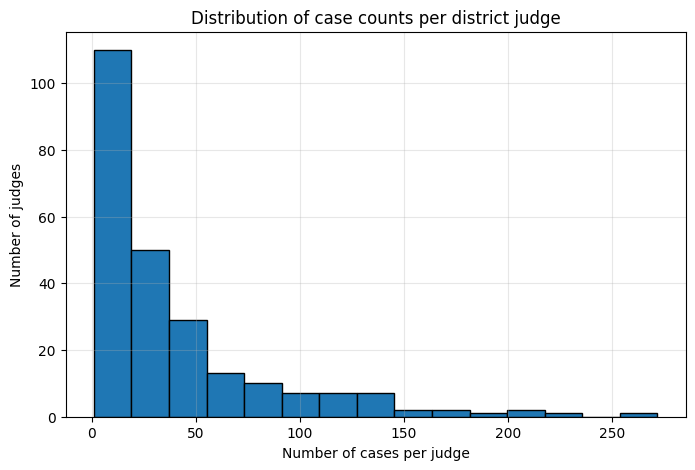

In [46]:
import pandas as pd
import matplotlib.pyplot as plt

# assuming your dataframe is cl_extracted (or similar)
df = cl.copy()

# count cases per judge id
cases_per_judge = (
    df['district judge id']
    .dropna()
    .astype(int)
    .value_counts()
)

# make a histogram (binning number of cases)
plt.figure(figsize=(8,5))
plt.hist(cases_per_judge, bins=15, edgecolor='black')
plt.xlabel("Number of cases per judge")
plt.ylabel("Number of judges")
plt.title("Distribution of case counts per district judge")
plt.grid(alpha=0.3)
plt.show()

In [77]:
judges.columns

Index(['judge id', 'last name', 'first name', 'gender', 'ethnicity',
       'birth year', 'birth city', 'birth state', 'death year', 'death city',
       'death state', 'court name', 'court type', 'appointment title',
       'appointing president', 'party of appointing president',
       'nomination date', 'termination date', 'termination', 'aba rating',
       'hearing date', 'judiciary committee action', 'committee action date',
       'senate vote type', 'ayes/nays', 'confirmation date', 'commission date',
       'school 1', 'degree 1', 'school 2', 'degree 2', 'professional career',
       'is_promoted', 'promotion_date'],
      dtype='object')

In [91]:
def load_case_results(path: str = "data/artifacts/api/outputs/cl_api_answers.jsonl") -> pd.DataFrame:
    records = []
    with open(path, "r", encoding="utf-8") as f:
        for line in f:
            if not line.strip():
                continue
            rec = json.loads(line)
            if rec.get("error"):
                continue
            try:
                content = rec["response"]["body"]["choices"][0]["message"]["content"]
                obj = json.loads(content)  # parse the 9-key JSON
            except Exception:
                continue
            obj["custom_id"] = rec.get("custom_id")  # keep your custom_id
            records.append(obj)
    return pd.DataFrame.from_records(records)

def attach_api_to_cl_clean(
    cl_clean: pd.DataFrame,
    api_path: str = "data/artifacts/api/outputs/cl_api_answers.jsonl",
    judges: pd.DataFrame = judges,
    *,
    id_col: str = "unique_id",
    case_name_col: str = "name",
    opinion_text_col: str = "opinion_text",
    docket_col: str = "docket_number",
    decision_date_col: str = "decision_date",
) -> pd.DataFrame:
    out = cl_clean.copy()

    # Mirror unique_id -> custom_id so your merge block stays identical
    out["custom_id"] = (
    out["unique_id"]
    .astype("string")
)

    # === Use your exact merge logic ===
    api_answers                 = load_case_results(api_path)
    api_answers                 = api_answers.copy()
    api_keys: List[str]         = [c for c in api_answers.columns if c != "custom_id"]

    # --- make lowercase for safe matching ---
    out["lower_judge_first"] = out["lower_judge_first"].str.strip().str.lower()
    out["lower_judge_last"]  = out["lower_judge_last"].str.strip().str.lower()
    judges["first name"]     = judges["first name"].str.strip().str.lower()
    judges["last name"]      = judges["last name"].str.strip().str.lower()

    out                         = out.merge(api_answers, left_on="custom_id", right_on="custom_id", how="left")

    out = out.merge(
        judges[["first name", "last name", "judge id"]],
        left_on=["lower_judge_last"],
        right_on=[ "last name"],
        how="left",
        suffixes=("", "_judge")
    )

    # --- fill district judge info only where a match exists ---
    mask = out["judge id"].notna()
    out.loc[mask, "district judge"] = out.loc[mask, "lower_judge_last"]
    out.loc[mask, "district judge id"] = out.loc[mask, "judge id"].astype("Int64")

    # --- clean up helper cols ---
    out.drop(columns=["first name", "last name"], errors="ignore", inplace=True)

    if "district judge id" in out.columns:
        out["district judge id"] = pd.to_numeric(out["district judge id"], errors="coerce").astype("Int64")

    base_cols = [id_col, case_name_col, opinion_text_col, docket_col, "district judge", "district judge id", decision_date_col]

    exclude_cols = {"lower_judge_first", "lower_judge_last"}
    api_cols     = [c for c in api_keys if c in out.columns and c not in exclude_cols]

    keep_cols = [c for c in base_cols if c in out.columns] + api_cols
    return out[keep_cols].reset_index(drop=True)

In [92]:
cl_clean = attach_api_to_cl_clean(cl)

KeyError: 'lower_judge_last'

In [86]:
cl_clean[cl_clean['district judge id'].isna()]

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level


In [53]:
cl_clean = cl_clean[cl_clean['opinion'].notna()]

In [54]:
cl_clean

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level
0,CL_0,NRA Group LLC v. Nicole Durenleau,PRECEDE...,24-1123,wilson,7330451,2025-10-07,affirmed,civil,legal error,company,group of individuals,2.0,low
1,CL_1,Andrew Perrong v. Matthew Bradford,PRECEDENTIA...,24-1925,wolson,6385006,2025-10-06,reversed,civil,legal error,male,male,3.0,medium
2,CL_2,Novo Nordisk Inc v. Secretary US Dept & Health...,PRECEDEN...,24-2510,quraishi,10236621,2025-10-06,affirmed,civil,legal error,company,other,4.0,high
3,CL_3,United States v. Natalya Shvets,PRECEDEN...,22-2683,robreno,2033,2025-09-29,remanded,criminal,legal error,female,other,1.0,low
4,CL_4,Bobrick Washroom Equipment Inc v. Scranton Pro...,PRECED...,23-2577,mariani,3397,2025-09-26,affirmed,civil,procedural error,company,company,1.0,medium
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9423,CL_32775,Clark v. Wheeling Steel Works,"WALES, District Judge.\n\nCm June 26, 1890, th...",No. 27,wales,2477,1893-01-03,affirmed,contract,legal error,company,company,1.0,medium
9425,CL_32780,New Chester Water Co. v. Holly Manuf'g Co.,"WALES, District Judge,\n\n(after stating the f...",No. 7,wales,2477,1892-11-14,affirmed,civil,legal error,company,company,1.0,low
9426,CL_32784,Yardley v. Clothier,"Wales, District Judge.\n\nThe case stated show...",NaN,wales,2477,1892-08-16,affirmed,bankruptcy,legal error,male,male,1.0,low
9427,CL_32785,In re Manderson,"Wales, District Judge.\n\nProceedings were ins...",NaN,wales,2477,1892-08-16,affirmed,civil,legal error,other,group of individuals,2.0,medium


In [55]:
def merge_cap_and_cl(cap: pd.DataFrame, cl: pd.DataFrame) -> pd.DataFrame:
    cap = cap.copy()
    cl  = cl.copy()

    # Normalize dockets for reliable matching
    cap["_dkey"] = cap["docket_number"].astype(str).str.strip()
    cl["_dkey"]  = cl["docket_number"].astype(str).str.strip()

    # Build fast lookup (first non-null per docket) for IDs and names from CL
    cl_id_map   = (cl[["_dkey", "district judge id"]]
                   .dropna(subset=["district judge id"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge id"])
    cl_name_map = (cl[["_dkey", "district judge"]]
                   .dropna(subset=["district judge"])
                   .drop_duplicates("_dkey")
                   .set_index("_dkey")["district judge"])

    # Fill CAP's missing judge id/name from CL where dockets match
    miss_id = cap["district judge id"].isna()
    cap.loc[miss_id, "district judge id"] = cap.loc[miss_id, "_dkey"].map(cl_id_map)

    if "district judge" in cap.columns:
        miss_name = cap["district judge"].isna()
        cap.loc[miss_name, "district judge"] = cap.loc[miss_name, "_dkey"].map(cl_name_map)

    # Append CL rows that don't overlap by docket
    non_overlap_cl = cl[~cl["_dkey"].isin(cap["_dkey"])]
    non_overlap_cl = non_overlap_cl.reindex(columns=cap.columns, fill_value=np.nan)

    out = pd.concat([cap, non_overlap_cl], ignore_index=True)
    return out.drop(columns=["_dkey"], errors="ignore")

In [56]:
full_data = merge_cap_and_cl(cap_clean, cl_clean)

In [57]:
full_data

,unique_id,name,opinion_text,docket_number,district judge,district judge id,decision_date,opinion,case_type,error_category,petitioner_type,respondent_type,politicality_score,profile_level
0,CAP_87597,"PHILADELPHIA INDEMNITY INSURANCE COMPANY, Appe...","OPINION OF THE COURT\nSMITH, Circuit Judge.\nP...",No. 04-2667,NaN,<NA>,2005-07-27 00:00:00,affirmed,contract,legal error,company,company,1.0,medium
1,CAP_87739,"DIMENSIONAL COMMUNICATIONS, INC. v. OZ OPTICS,...","OPINION OF THE COURT\nPOLLAK, District Judge.\...",No. 04-1817,bassler,114,2005-08-12 00:00:00,affirmed,contract,abuse of discretion,company,company,1.0,low
2,CAP_87689,"Martin BRODY; Florence Brody; MFB Partners, L....","OPINION OF THE COURT\nSMITH, Circuit Judge.\nW...",No. 04-1376,joyner,1212,2005-08-29 00:00:00,reversed and remanded,civil,legal error,group of individuals,male,1.0,low
3,CAP_87025,LAW OFFICES OF CHRISTOPHER S. LUCAS & ASSOCIAT...,"OPINION OF THE COURT\nRENDELL, Circuit Judge.\...",No. 04-2695,jones,2946,2005-04-04 00:00:00,affirmed,civil,legal error,male,group of individuals,2.0,medium
4,CAP_87033,"Cynthia A. EBBERT, Appellant, v. DAIMLERCHRYSL...","OPINION OF THE COURT\nGREENBERG, Circuit Judge...",No. 04-2143,sleet,2772,2005-04-14 00:00:00,affirmed,civil,insufficient evidence,female,company,2.0,high
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12478,CL_32775,Clark v. Wheeling Steel Works,"WALES, District Judge.\n\nCm June 26, 1890, th...",No. 27,wales,2477,1893-01-03,affirmed,contract,legal error,company,company,1.0,medium
12479,CL_32780,New Chester Water Co. v. Holly Manuf'g Co.,"WALES, District Judge,\n\n(after stating the f...",No. 7,wales,2477,1892-11-14,affirmed,civil,legal error,company,company,1.0,low
12480,CL_32784,Yardley v. Clothier,"Wales, District Judge.\n\nThe case stated show...",NaN,wales,2477,1892-08-16,affirmed,bankruptcy,legal error,male,male,1.0,low
12481,CL_32785,In re Manderson,"Wales, District Judge.\n\nProceedings were ins...",NaN,wales,2477,1892-08-16,affirmed,civil,legal error,other,group of individuals,2.0,medium


In [60]:
judges[judges['judge id']==2477]

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,ayes/nays,confirmation date,commission date,school 1,degree 1,school 2,degree 2,professional career,is_promoted,promotion_date
3737,2477,wales,Leonard,Male,White,1823,Wilmington,DE,1897.0,Wilmington,...,,1884-03-20,1884-03-20,Yale College,NaN,Read law,NaN,"Editor, Delaware State Journal, Wilmington, De...",0,NaT


In [15]:
full_data = full_data[full_data['opinion'].notna()]

In [31]:
full_data = full_data[full_data['district judge id'].notna()]

In [38]:
import pandas as pd, numpy as np

def compute_overturns(judges: pd.DataFrame, full_data: pd.DataFrame) -> pd.DataFrame:
    df = full_data.copy()
    df["judge id"]      = pd.to_numeric(df["district judge id"], errors="coerce").astype("Int64")
    df["opinion"]       = df["opinion"].astype(str).str.lower()
    df["decision_date"] = pd.to_datetime(df["decision_date"], errors="coerce")

    j = judges.copy()
    j["promotion_date"] = pd.to_datetime(j["promotion_date"], errors="coerce")
    j["cutoff"]         = j["promotion_date"] - pd.DateOffset(months=0)

    m = df.merge(j[["judge id","cutoff"]], on="judge id", how="inner")
    m = m[m["decision_date"].notna() & (m["cutoff"].isna() | (m["decision_date"] <= m["cutoff"]))]

    counts = m.groupby("judge id", dropna=True).agg(
        appealed_cases=("unique_id","count"),
        overturned_appealed_cases=("opinion", lambda x: (x != "affirmed").sum())
    )

    out = j.merge(counts, on="judge id", how="left")
    out[["appealed_cases","overturned_appealed_cases"]] = out[["appealed_cases","overturned_appealed_cases"]].fillna(0).astype(int)
    out["overturnrate"] = np.where(out["appealed_cases"] > 0,
                                   out["overturned_appealed_cases"] / out["appealed_cases"], np.nan)
    return out

In [65]:
feature_dataset = compute_overturns(judges, cl_clean)

In [66]:
feature_dataset = feature_dataset[feature_dataset["appealed_cases"] > 0]

In [67]:
feature_dataset

,judge id,last name,first name,gender,ethnicity,birth year,birth city,birth state,death year,death city,...,degree 1,school 2,degree 2,professional career,is_promoted,promotion_date,cutoff,appealed_cases,overturned_appealed_cases,overturnrate
5,4,ackerman,Harold,Male,White,1928,Newark,NJ,2009.0,West Orange,...,LL.B.,NaN,NaN,"Private practice, New Jersey, 1951-1954; Judge...",0,NaT,NaT,9,3,0.333333
49,37,ambrose,Donetta,Female,White,1945,New Kensington,PA,NaN,,...,B.A.,Duquesne University School of Law,J.D.,"Law clerk, Hon. Louis Manderino, Commonwealth ...",0,NaT,NaT,81,31,0.382716
64,3402,andrews,Richard,Male,White,1955,Manchester,England,NaN,,...,B.A.,"University of California, Berkeley, School of Law",J.D.,"Law clerk, Hon. Collins J. Seitz, U.S. Court o...",0,NaT,NaT,34,20,0.588235
74,3568,arleo,Madeline,Female,White,1963,Jersey City,NJ,NaN,,...,B.A.,Rutgers University,M.A.,"Law clerk, Hon. Marie L. Garibaldi, Supreme Co...",0,NaT,NaT,23,1,0.043478
89,71,augelli,Anthony,Male,White,1902,Orsara,Italy,1985.0,Spring Lake Heights,...,LL.B.,Mercer Beasley School of Law (now Rutgers Scho...,LL.M.,"Private practice, Jersey City, New Jersey, 193...",0,NaT,NaT,5,2,0.400000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3228,2656,wortendyke,Reynier,Male,White,1895,Jersey City,NJ,1975.0,,...,A.B.,Columbia Law School,LL.B.,"Township attorney, Millburn Township, New Jers...",0,NaT,NaT,9,2,0.222222
3229,2657,wright,Caleb,Male,White,1908,Georgetown,DE,2001.0,,...,B.A.,Yale Law School,LL.B.,"Private practice, Georgetown, Delaware, 1933-1...",0,NaT,NaT,1,1,1.000000
3247,2671,yohn,William,Male,White,1935,Pottstown,PA,NaN,,...,NaN,Princeton University,B.A.,"U.S. Marine Corps Reserve, 1960-1965; active d...",0,NaT,NaT,62,8,0.129032
3259,6839686,younge,John,Male,African American,1955,Philadelphia,PA,NaN,NaN,...,B.A.,Howard University School of Law,J.D.,"Private practice, Philadelphia, Pennsylvania, ...",0,NaT,NaT,7,5,0.714286


In [68]:
# Regression analysis with gender and ethnicity
y = feature_dataset["is_promoted"].astype(float)  
X = pd.DataFrame({
    "overturnrate": pd.to_numeric(feature_dataset["overturnrate"], errors="coerce"),

})


mask = ~(y.isna() | X.isna().any(axis=1))
y_clean = y.loc[mask]
X_clean = X.loc[mask]

X_clean = sm.add_constant(X_clean, has_constant="add")

logit_model = sm.Logit(y_clean, X_clean).fit(maxiter=100)
print("=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(logit_model.summary())

ols_model = sm.OLS(y_clean, X_clean).fit(maxiter=100)
print("\n=== OLS Regression: is promoted ~ overturnrate + gender + ethnicity ===")
print(ols_model.summary())

Optimization terminated successfully.
         Current function value: 0.124316
         Iterations 8
=== Logistic Regression: is promoted ~ overturnrate + gender + ethnicity ===
                           Logit Regression Results                           
Dep. Variable:            is_promoted   No. Observations:                  221
Model:                          Logit   Df Residuals:                      219
Method:                           MLE   Df Model:                            1
Date:                Fri, 10 Oct 2025   Pseudo R-squ.:                0.002991
Time:                        10:14:50   Log-Likelihood:                -27.474
converged:                       True   LL-Null:                       -27.556
Covariance Type:            nonrobust   LLR p-value:                    0.6847
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -3.8259    